# Import libraries and set up Parameters
This is a good dataset about type of signals in the field radio communications

In [1]:
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
import pathlib 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import os
import random
#setup variables & seeds
batch_size = 64
img_height = 128
img_width = 128
epochs = 40
DEFAULT_RANDOM_SEED = 22

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# tensorflow random seed 
import tensorflow as tf 
def seedTF(seed=DEFAULT_RANDOM_SEED):
    tf.random.set_seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTF(seed)
    seedTorch(seed)
seedEverything(113)
training_dir = pathlib.Path('../input/radardataset/training_set')
training_count = len(list(training_dir.glob('*/*.png')))
print(training_count)

test_dir = pathlib.Path('../input/radardataset/test_set')
test_count = len(list(test_dir.glob('*/*.png')))
print(test_count)
#make a training dataset from direction
train_ds = tf.keras.utils.image_dataset_from_directory(
  training_dir,
  validation_split=0,2
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  validation_split=0,2
  seed=113,
  image_size=(img_height, img_width),
  batch_size=batch_size)

2024-05-16 08:07:52.883027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 08:07:52.883175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 08:07:53.019108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


6400
4800
Found 6400 files belonging to 8 classes.
Found 4800 files belonging to 8 classes.


# Check the classnames and draw target class distribution pie chart

In [2]:
train_ds.class_names

['B-FM', 'Barker', 'CPFSK', 'DSB-AM', 'GFSK', 'LFM', 'Rect', 'SSB-AM']

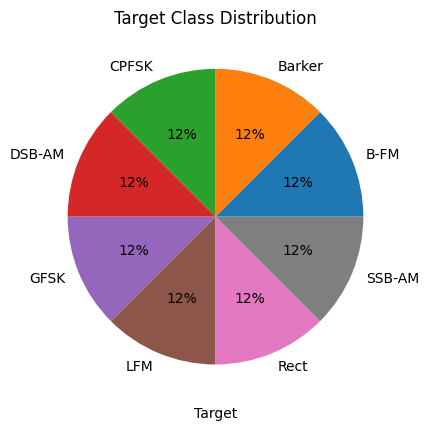

In [3]:
unique,count=np.unique(train_ds.class_names,return_counts=True)
plt.pie(x=count,labels=unique,autopct='%.0f%%')
plt.xlabel('Target')
plt.title('Target Class Distribution')
plt.show()

# Build model Xceptionv3-inspired and set up some call back

In [24]:
def create_xceptionv3_model(img_rows, img_cols, channels, num_classes):
    # Input shape
    inputs = layers.Input(shape=(img_rows, img_cols, channels))

    # Entry flow (adjusted for 128x128 input)
    x = layers.Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Middle flow (repeat 6 times, reduced filters)
    for _ in range(8):
        # Separable convolution block with residual connection
        residual = x
        x = layers.Conv2D(16, (1, 1), use_bias=False, activation='relu')(x)  # Reduce filter size in 1x1 conv
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, residual])  # Add residual connection

    # Exit flow (reduced filters)
    x = layers.SeparableConv2D(128, (3, 3), padding='same', use_bias=False, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(256, (3, 3), padding='same', use_bias=False, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Classification head
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=inputs, outputs=predictions)

    # Compile the model
    #model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model
model = create_xceptionv3_model(128,128,3,8)

model.summary()

#some callbacks
checkpoint_filepath = '/kaggle/working/checkpoint.weights.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='auto')
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_128 (Conv2D) │ (None, 63, 63,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │        128 │ conv2d_128[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_129 (Conv2D) │ (None, 63, 63,    │     18,432 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │        256 │ conv2d_129[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_130 (Conv2D) │ (None, 31, 31,    │      1,024 │ max_pooling2d_7[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │         64 │ conv2d_130[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_131 (Conv2D) │ (None, 31, 31,    │      9,216 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        256 │ conv2d_131[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_56 (Add)        │ (None, 31, 31,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_132 (Conv2D) │ (None, 31, 31,    │      1,024 │ add_56[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │         64 │ conv2d_132[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_133 (Conv2D) │ (None, 31, 31,    │      9,216 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        256 │ conv2d_133[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_57 (Add)        │ (None, 31, 31,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ add_56[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_134 (Conv2D) │ (None, 31, 31,    │      1,024 │ add_57[0][0]    

 Total params: 150,440 (587.66 KB)

 Trainable params: 148,200 (578.91 KB)

 Non-trainable params: 2,240 (8.75 KB)

# Start training with 40 epochs and all the callbacks

In [25]:
epochs=40
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, shuffle=True, callbacks=[learning_rate_reduction,model_checkpoint_callback])


Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.4505 - loss: 1.3359 - val_accuracy: 0.1735 - val_loss: 2.1192 - learning_rate: 0.0010
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.7487 - loss: 0.6256 - val_accuracy: 0.1871 - val_loss: 3.0220 - learning_rate: 0.0010
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.7983 - loss: 0.4815 - val_accuracy: 0.3808 - val_loss: 3.1546 - learning_rate: 0.0010
Epoch 4/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8147 - loss: 0.4385
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8148 - loss: 0.4380 - val_accuracy: 0.3983 - val_loss: 3.7386 - learning_rate: 0.0010
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8333 - loss: 0.3634 - val_accuracy: 0.7233 - val_loss: 0.6779 - learning_rate: 5.0000e-04
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8499 - loss

# Get the best weights model and show accuracy

In [26]:
model.load_weights(checkpoint_filepath)
model.summary()
accuracy = model.evaluate(val_ds)
print(accuracy[1])

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_128 (Conv2D) │ (None, 63, 63,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │        128 │ conv2d_128[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_129 (Conv2D) │ (None, 63, 63,    │     18,432 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │        256 │ conv2d_129[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_130 (Conv2D) │ (None, 31, 31,    │      1,024 │ max_pooling2d_7[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │         64 │ conv2d_130[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_131 (Conv2D) │ (None, 31, 31,    │      9,216 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        256 │ conv2d_131[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_56 (Add)        │ (None, 31, 31,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_132 (Conv2D) │ (None, 31, 31,    │      1,024 │ add_56[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │         64 │ conv2d_132[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_133 (Conv2D) │ (None, 31, 31,    │      9,216 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        256 │ conv2d_133[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_57 (Add)        │ (None, 31, 31,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ add_56[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_134 (Conv2D) │ (None, 31, 31,    │      1,024 │ add_57[0][0]    

 Total params: 446,842 (1.70 MB)

 Trainable params: 148,200 (578.91 KB)

 Non-trainable params: 2,240 (8.75 KB)

 Optimizer params: 296,402 (1.13 MB)

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7924 - loss: 0.4036
0.8087499737739563


# Draw Accuracy and Loss chart

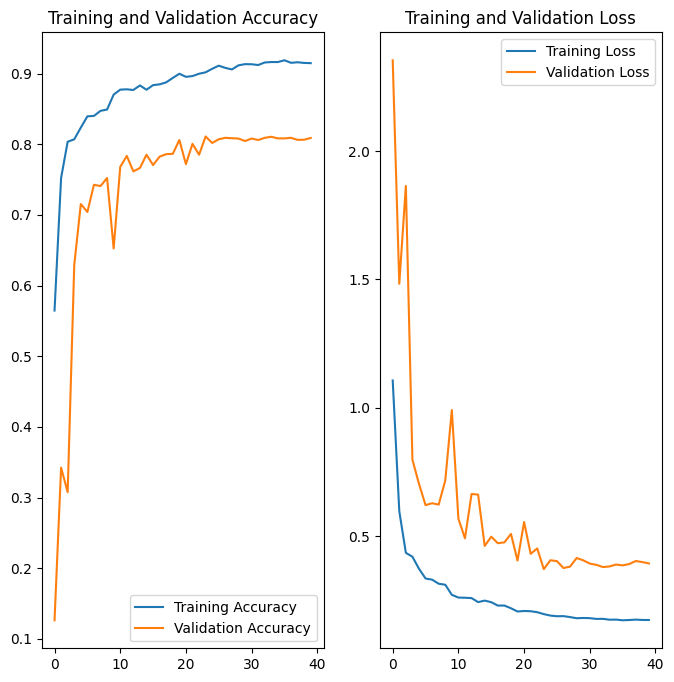

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
# def residual_block(x, filters):
#     # Shortcut connection
#     shortcut = x

#     # First convolutional layer
#     y = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x)
#     y = layers.BatchNormalization()(y) 
#     y = layers.Activation("relu")(y)
    
#     # Second convolutional layer
#     y = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(y)
#     y = layers.BatchNormalization()(y) 
    
#     # Add skip connection and activation
#     out = layers.Add()([shortcut, y])
#     #out = layers.BatchNormalization()(out)
#     out = layers.Activation("relu")(out)
#     return y

# inputs = keras.Input(shape=(128, 128, 3))

# x = layers.Conv1D(32, kernel_size=(7, 7), strides=(2, 2), padding="same")(inputs)
# x = residual_block(x, 32)

# x = layers.Conv1D(64, kernel_size=(7, 7), strides=(2, 2), padding="same")(x)
# x = residual_block(x, 64)

# # Final layer
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.4)(x)
# outputs = layers.Dense(8, activation="softmax")(x) 

# model = keras.Model(inputs=inputs, outputs=outputs)
#----------------------------------------------------
# from tensorflow.keras import layers, Model

# def create_dense_net(img_rows, img_cols, channels, num_classes):
#     # Input shape
#     inputs = layers.Input(shape=(img_rows, img_cols, channels))

#     # Initial convolution
#     x = layers.Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same')(inputs)

#     # Dense block (repeat 4 times)
#     for _ in range(8):
#         # Bottleneck layer
#         bn_out = layers.Conv2D(4, (1, 1), activation='relu', padding='same')(x)
#         # Convolution layer
#         x = layers.Conv2D(32, (3, 3), padding='same')(bn_out)
#         # Concatenate with previous feature maps
#         x = layers.Concatenate()([x, bn_out])

#     # Transition layer
#     x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
#     x = layers.Conv2D(64, (1, 1), activation='relu', padding='same')(x)

#     # Global average pooling
#     x = layers.GlobalAveragePooling2D()(x)

#     # Dense layers
#     x = layers.Dense(128, activation='relu')(x)
#     predictions = layers.Dense(num_classes, activation='softmax')(x)

#     # Create the final model
#     model = Model(inputs=inputs, outputs=predictions)
    
#     return model
#_______________________________________________________
# def create_xception_model(img_rows, img_cols, channels, num_classes):
#     # Define input shape
#     inputs = layers.Input(shape=(img_rows, img_cols, channels))

#     # Entry flow (simplified)
#     x = layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(inputs)
#     x = layers.BatchNormalization()(x)  # Add BatchNormalization for stability
#     x = layers.Conv2D(64, (3, 3), padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

#     # Middle flow (repeat 4 times, simplified)
#     for _ in range(4):
#         # Separable convolution block
#         residual = x
#         x = layers.Conv2D(32, (1, 1), activation='relu', padding='same')(x)
#         x = layers.Conv2D(64, (3, 3), padding='same')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Activation('relu')(x)
#         x = layers.Add()([x, residual])  # Add residual connection

#     # Exit flow (simplified)
#     x = layers.Conv2D(64, (1, 1), activation='relu', padding='same')(x)
#     x = layers.Conv2D(128, (3, 3), padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.GlobalAveragePooling2D()(x)

#     # Classification head
#     predictions = layers.Dense(num_classes, activation='softmax')(x)

#     # Create the final model
#     model = Model(inputs=inputs, outputs=predictions)

#     # Compile the model
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#     return model
#_______________________________________________________